In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List

In [2]:
pd.set_option("display.max_rows", 100)

### Masking strategies

Sentence : 'EU rejects German call to boycott British lamb .'

Entities: EU, German, British


**No Mask**: 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.' (Baseline)

**Mask Entity**: '*[MASK]*', 'rejects', '*[MASK]*', 'call', 'to', 'boycott', '*[MASK]*', 'lamb', '.'

**Mask Context Windows**: 'EU', '*[MASK]*', 'German', '*[MASK]*', 'to', '*[MASK]*', 'British', '*[MASK]*', '.' (windows size = 1)

**Mask Outside Windows**: 'EU', 'rejects', 'German', 'call', '*[MASK]*', 'boycott', 'British', 'lamb', '*[MASK]*' (windows size = 1)


In [3]:
class FilterMaskedResults:
    def __init__(self, masked_df):
        self.masked_df = masked_df

    def __call__(self, baseline_df, dataset_by: str="conll2003", model_by: str="google-bert/bert-base-cased", group_by=[], drop_columns=[], sort_by="mask_ratio"):
        assert group_by and drop_columns
        filtered_df = self.filter(dataset_by, model_by, group_by)
        concatenated_df = self._insert_baseline(filtered_df, baseline_df).drop(columns=drop_columns).reset_index(drop=True).sort_values(by=sort_by)
        return concatenated_df
    
    def filter(self, dataset_by: str="conll2003", model_by: str="google-bert/bert-base-cased", group_by=[]):
        assert group_by
        filtered_df = self._filter(self.masked_df, dataset_by=dataset_by, model_by=model_by)
        filtered_df = filtered_df.groupby(group_by).mean().reset_index()
        return filtered_df
        
    @staticmethod
    def _filter(dataframe, dataset_by: str="conll", model_by: str="google-bert/bert-base-cased"):
        return dataframe.loc[(dataframe.dataset.str.contains(dataset_by)) & (dataframe.model.str.contains(model_by))].reset_index(drop=True)

    @staticmethod
    def _insert_baseline(filtered_df, baselines_df):
        return pd.concat([filtered_df, baselines_df.loc[(baselines_df.dataset.isin(filtered_df.dataset)) & (baselines_df.model.isin(filtered_df.model))]]).fillna(0.0)

In [4]:
# Context masking -> compare different strategies and masking windows sizes
def plot_context_masking_results(*hue, inp_data, pivot_col, pivot_ind, pivot_values, title):
    pivoted_data = inp_data.pivot(columns="strategy", index=["mask_ratio", "windows_size"], values="f1").reset_index()
    pivoted_data["windows"] = pivoted_data["windows"].fillna(pivoted_data["no_mask"])
    pivoted_data["outside"] = pivoted_data["outside"].fillna(pivoted_data["no_mask"])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=True)
    for i,size in enumerate(hue):
        pivoted_data.loc[pivoted_data.windows_size==size].plot(x="mask_ratio", 
                                                               y=["outside", "windows"], 
                                                               kind="line",
                                                               grid=True, 
                                                               xlim=(-0.05, 1.05),
                                                               style=["r*-", "b*-", "g*-"],
                                                               title=f"Mask windows size={size}",
                                                               ax=ax[i]
                                                              )
    plt.setp(ax, xlabel="Mask probability")
    plt.setp(ax[0], ylabel="F1")
    fig.suptitle(title, size=14)

def plot_context_masking_plm_results(*hue, dataframes, pivot_col, pivot_ind, pivot_values, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=True)
    pivoted_data = pd.concat([df for df in dataframes]).pivot(columns=pivot_col, index=pivot_ind, values=pivot_values).reset_index()
    for i,size in enumerate(hue):
        pivoted_data.loc[(pivoted_data.windows_size==size) | (pivoted_data.windows_size == 0)].plot(x="mask_ratio", 
                 y=["FacebookAI/roberta-base", "FacebookAI/xlm-roberta-base", "google-bert/bert-base-cased"], 
                 kind="line",
                 grid=True, 
                 xlabel="Masking probability",
                 ylabel="F1",
                 xlim=(-0.05, 1.05),
                 style=["r*-", "b*-", "g*-"],
                 title=f"Windows size={size}",
                 ax=ax[i]
                 )
    plt.suptitle(title, size=14)

## Read and prepare data

In [5]:
grid_search_results_df = pd.read_csv("./results_baseline.tsv", delimiter="\t")
entity_mask_results_df = pd.read_csv("./results_mask_entity.tsv", delimiter="\t")
context_mask_results_df = pd.read_csv("./results_mask_context.tsv", delimiter="\t")

In [6]:
# Filter grid search results to get best settings
baselines_df = grid_search_results_df.loc[grid_search_results_df.groupby(["dataset", "model"])["f1"].idxmax()].reset_index(drop=True)

# Filter masked results based on dataset and model
filter_entity_masked_results = FilterMaskedResults(entity_mask_results_df)
filter_context_masked_results = FilterMaskedResults(context_mask_results_df)


context_mask_results_conll = context_mask_results_df[context_mask_results_df["dataset"].str.contains("conll2003")]
context_mask_results_wnut = context_mask_results_df[context_mask_results_df["dataset"].str.contains("wnut")]

# Average masking results for all runs
avg_conll_context_results = context_mask_results_conll.groupby(["dataset", 
                                                                "model", 
                                                                "windows_size", 
                                                                "strategy",
                                                                "mask_ratio", 
                                                                "epochs",
                                                                "learning_rate",
                                                                "batch"
                                                               ]).mean().reset_index().drop(columns=["run"])
avg_wnut_context_results = context_mask_results_wnut.groupby(["dataset",
                                                              "model",
                                                              "windows_size", 
                                                              "strategy",
                                                              "mask_ratio",
                                                              "epochs", 
                                                              "learning_rate",
                                                              "batch"
                                                             ]).mean().reset_index().drop(columns=["run"])

In [7]:
# Entity Masking
# CONLL
conll_bert_entity_masked = filter_entity_masked_results(baselines_df, 
                                                        dataset_by="conll2003", 
                                                        model_by="google-bert/bert-base-cased",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run", "windows_size", "strategy"]
                                                       )
conll_roberta_entity_masked = filter_entity_masked_results(baselines_df, 
                                                        dataset_by="conll2003", 
                                                        model_by="FacebookAI/roberta-base",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run", "windows_size", "strategy"]
                                                       )
conll_xlmr_entity_masked = filter_entity_masked_results(baselines_df, 
                                                        dataset_by="conll2003", 
                                                        model_by="FacebookAI/xlm-roberta-base",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run", "windows_size", "strategy"]
                                                       )

# WNUT
wnut_bert_entity_masked = filter_entity_masked_results(baselines_df, 
                                                        dataset_by="wnut", 
                                                        model_by="google-bert/bert-base-cased",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run", "windows_size", "strategy"]
                                                       )
wnut_roberta_entity_masked = filter_entity_masked_results(baselines_df, 
                                                        dataset_by="wnut", 
                                                        model_by="FacebookAI/roberta-base",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run", "windows_size", "strategy"]
                                                       )
wnut_xlmr_entity_masked = filter_entity_masked_results(baselines_df, 
                                                        dataset_by="wnut", 
                                                        model_by="FacebookAI/xlm-roberta-base",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run", "windows_size", "strategy"]
                                                       )

In [8]:
# Context masking
# CONLL
conll_bert_context_masked = filter_context_masked_results(baselines_df, 
                                                        dataset_by="conll2003", 
                                                        model_by="google-bert/bert-base-cased",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run"],
                                                        sort_by=["strategy", "windows_size", "mask_ratio"]
                                                       )
conll_bert_context_windows_masked = conll_bert_context_masked[conll_bert_context_masked["strategy"].isin(["no_mask", "windows"])].reset_index(drop=True)
conll_bert_context_outside_masked = conll_bert_context_masked[conll_bert_context_masked["strategy"].isin(["no_mask", "outside"])].reset_index(drop=True)

conll_roberta_context_masked = filter_context_masked_results(baselines_df, 
                                                        dataset_by="conll2003", 
                                                        model_by="FacebookAI/roberta-base",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run"],
                                                        sort_by=["strategy", "windows_size", "mask_ratio"]
                                                       )
conll_roberta_context_windows_masked = conll_roberta_context_masked[conll_roberta_context_masked["strategy"].isin(["no_mask", "windows"])].reset_index(drop=True)
conll_roberta_context_outside_masked = conll_roberta_context_masked[conll_roberta_context_masked["strategy"].isin(["no_mask", "outside"])].reset_index(drop=True)

conll_xlmr_context_masked = filter_context_masked_results(baselines_df, 
                                                        dataset_by="conll2003", 
                                                        model_by="FacebookAI/xlm-roberta-base",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run"],
                                                        sort_by=["strategy", "windows_size", "mask_ratio"]
                                                       )
conll_xlmr_context_windows_masked = conll_xlmr_context_masked[conll_xlmr_context_masked["strategy"].isin(["no_mask", "windows"])].reset_index(drop=True)
conll_xlmr_context_outside_masked = conll_xlmr_context_masked[conll_xlmr_context_masked["strategy"].isin(["no_mask", "outside"])].reset_index(drop=True)

# WNUT
wnut_bert_context_masked = filter_context_masked_results(baselines_df, 
                                                        dataset_by="wnut", 
                                                        model_by="google-bert/bert-base-cased",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run"],
                                                        sort_by=["strategy", "windows_size", "mask_ratio"]
                                                       )
wnut_bert_context_windows_masked = wnut_bert_context_masked[wnut_bert_context_masked["strategy"].isin(["no_mask", "windows"])].reset_index(drop=True)
wnut_bert_context_outside_masked = wnut_bert_context_masked[wnut_bert_context_masked["strategy"].isin(["no_mask", "outside"])].reset_index(drop=True)

wnut_roberta_context_masked= filter_context_masked_results(baselines_df, 
                                                        dataset_by="wnut", 
                                                        model_by="FacebookAI/roberta-base",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run"],
                                                        sort_by=["strategy", "windows_size", "mask_ratio"]
                                                       )
wnut_roberta_context_windows_masked = wnut_roberta_context_masked[wnut_roberta_context_masked["strategy"].isin(["no_mask", "windows"])].reset_index(drop=True)
wnut_roberta_context_outside_masked = wnut_roberta_context_masked[wnut_roberta_context_masked["strategy"].isin(["no_mask", "outside"])].reset_index(drop=True)

wnut_xlmr_context_masked = filter_context_masked_results(baselines_df, 
                                                        dataset_by="wnut", 
                                                        model_by="FacebookAI/xlm-roberta-base",
                                                        group_by=["dataset", "model", "windows_size", "strategy", "mask_ratio", "epochs", "learning_rate", "batch"], 
                                                        drop_columns=["run"],
                                                        sort_by=["strategy", "windows_size", "mask_ratio"]
                                                       )
wnut_xlmr_context_windows_masked = wnut_xlmr_context_masked[wnut_xlmr_context_masked["strategy"].isin(["no_mask", "windows"])].reset_index(drop=True)
wnut_xlmr_context_outside_masked = wnut_xlmr_context_masked[wnut_xlmr_context_masked["strategy"].isin(["no_mask", "outside"])].reset_index(drop=True)

### Results

#### CONLL

<Axes: title={'center': 'Evaluate entity masking on CONLL across different PLMs'}, xlabel='Masking probability', ylabel='F1'>

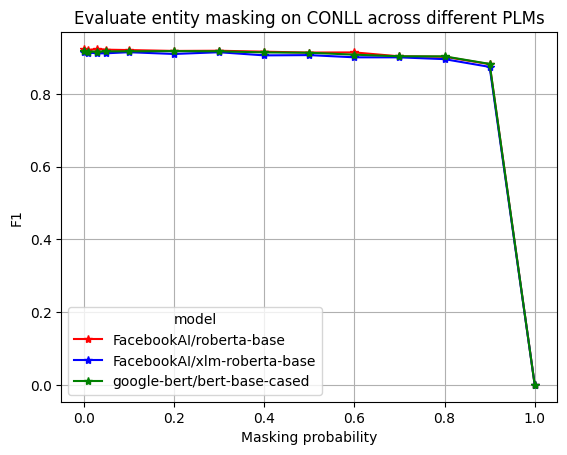

In [9]:
# Entity Masking -> Compare different models
# This results show that CONLL could contain lots ofname regularities which lead to similar good results even if only a small fraction of the entities is not masked 
pd.concat([conll_bert_entity_masked, conll_roberta_entity_masked, conll_xlmr_entity_masked]).pivot(columns="model", index="mask_ratio", values="f1").reset_index().plot(x="mask_ratio", 
             y=["FacebookAI/roberta-base", "FacebookAI/xlm-roberta-base", "google-bert/bert-base-cased"], 
             kind="line",
             grid=True, 
             xlabel="Masking probability",
             ylabel="F1",
             xlim=(-0.05, 1.05),
             style=["r*-", "b*-", "g*-"],
             title="Evaluate entity masking on CONLL across different PLMs"
             )

In [10]:
# Context masking

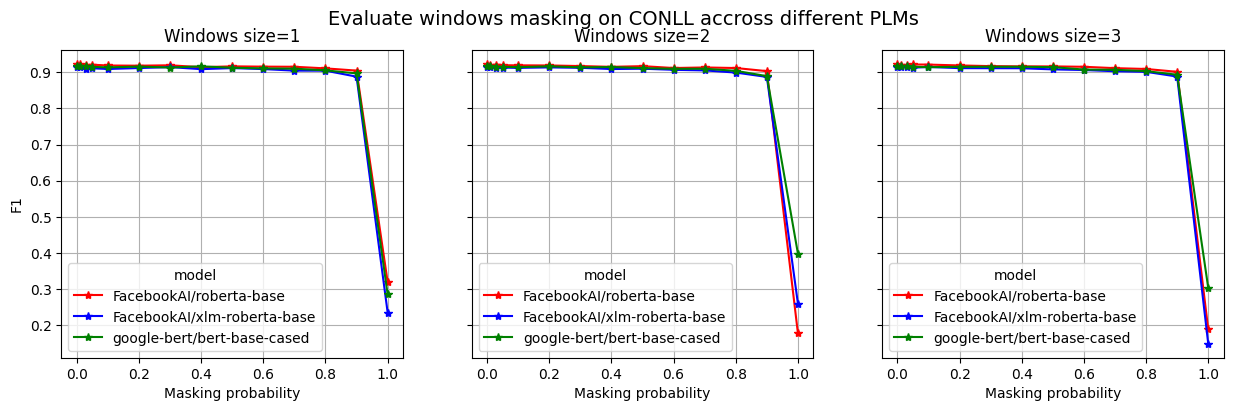

In [11]:
plot_context_masking_plm_results(1,2,3, 
                                 dataframes=[conll_bert_context_windows_masked, 
                                                    conll_roberta_context_windows_masked, 
                                                    conll_xlmr_context_windows_masked], 
                                 pivot_col="model",
                                 pivot_ind=["mask_ratio", "windows_size"], 
                                 pivot_values="f1",
                                 title="Evaluate windows masking on CONLL accross different PLMs")

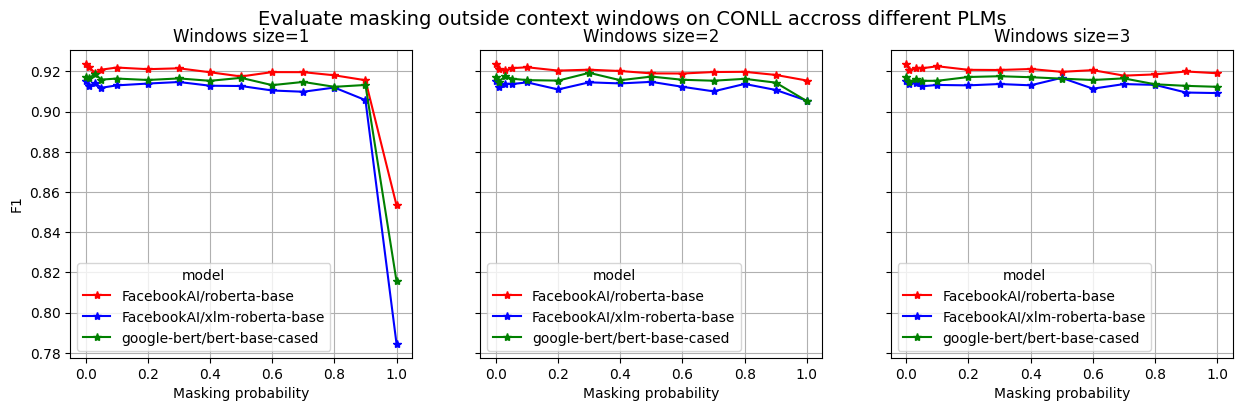

In [12]:
plot_context_masking_plm_results(1,2,3, 
                                 dataframes=[conll_bert_context_outside_masked, 
                                             conll_roberta_context_outside_masked, 
                                             conll_xlmr_context_outside_masked], 
                                 pivot_col="model",
                                 pivot_ind=["mask_ratio", "windows_size"], 
                                 pivot_values="f1",
                                 title="Evaluate masking outside context windows on CONLL accross different PLMs")

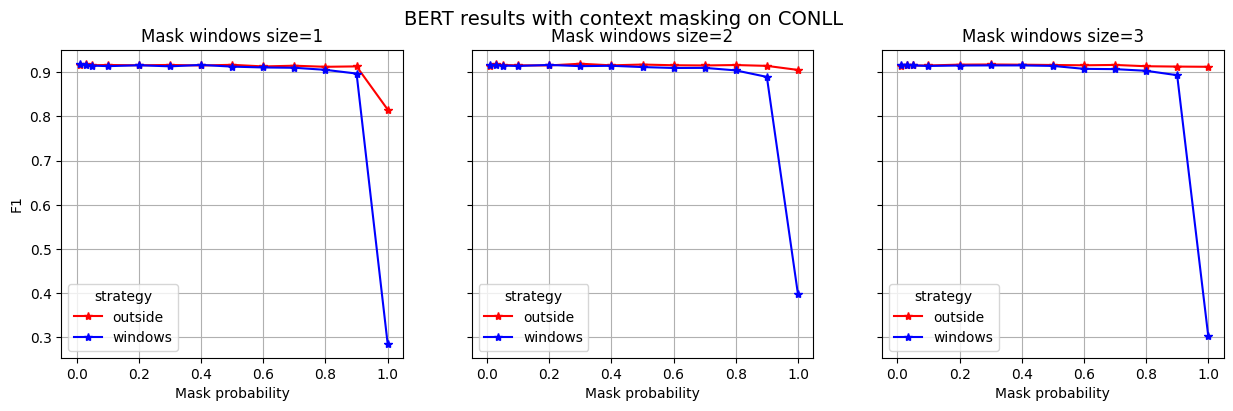

In [13]:
plot_context_masking_results(1, 2, 3, inp_data=conll_bert_context_masked, pivot_col="strategy", pivot_ind=["mask_ratio", "windows_size"], pivot_values="f1", title="BERT results with context masking on CONLL")

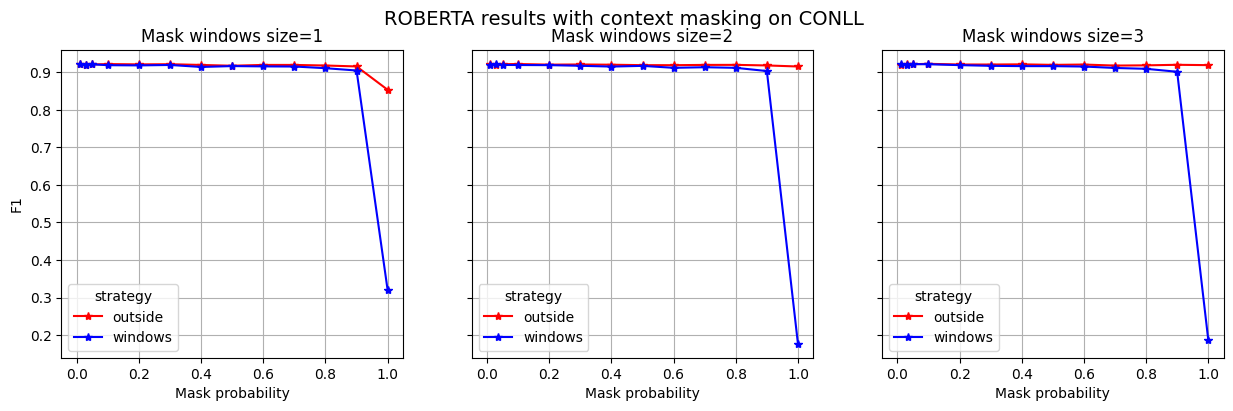

In [14]:
plot_context_masking_results(1, 2, 3, inp_data=conll_roberta_context_masked, pivot_col="strategy", pivot_ind=["mask_ratio", "windows_size"], pivot_values="f1", title="ROBERTA results with context masking on CONLL")

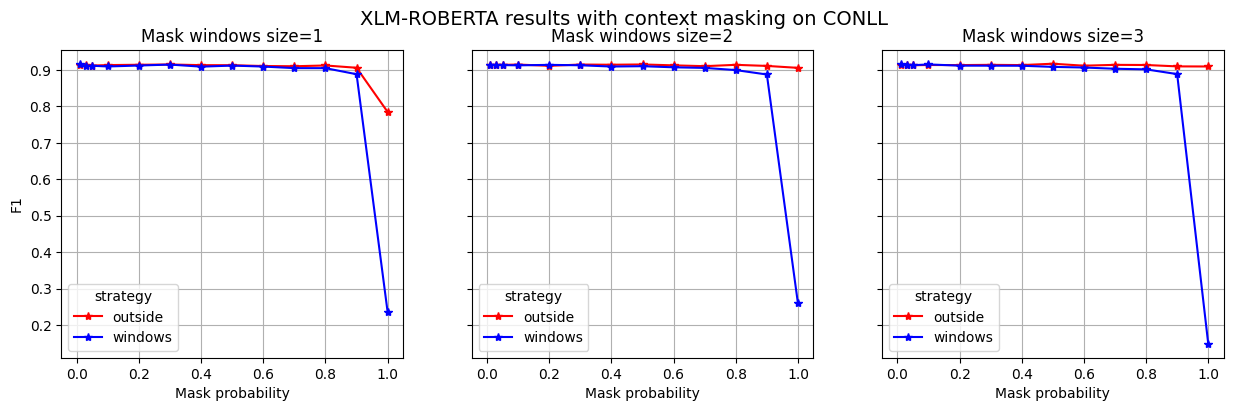

In [15]:
plot_context_masking_results(1, 2, 3, inp_data=conll_xlmr_context_masked, pivot_col="strategy", pivot_ind=["mask_ratio", "windows_size"], pivot_values="f1", title="XLM-ROBERTA results with context masking on CONLL")

#### WNUT

<Axes: title={'center': 'Evaluate entity masking on WNUT across different PLMs'}, xlabel='Mask probability', ylabel='F1'>

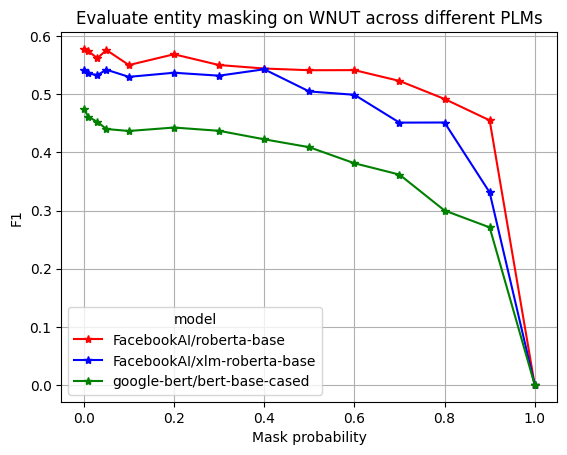

In [16]:
# Entity Masking -> Compare different models
pd.concat([wnut_bert_entity_masked, wnut_roberta_entity_masked, wnut_xlmr_entity_masked]).pivot(columns="model", index="mask_ratio", values="f1").reset_index().plot(x="mask_ratio", 
             y=["FacebookAI/roberta-base", "FacebookAI/xlm-roberta-base", "google-bert/bert-base-cased"], 
             kind="line",
             grid=True, 
             xlabel="Mask probability",
             ylabel="F1",
             xlim=(-0.05, 1.05),
             style=["r*-", "b*-", "g*-"],
             title="Evaluate entity masking on WNUT across different PLMs"
             )

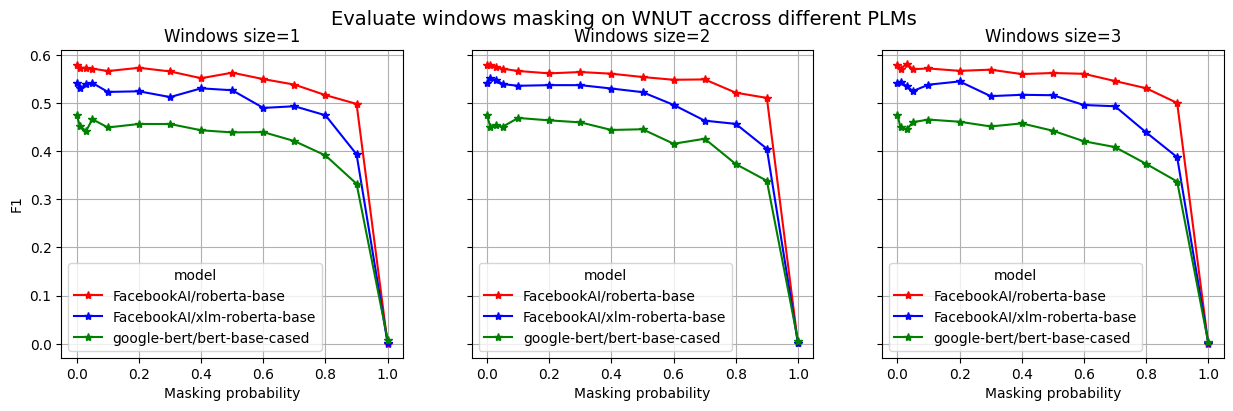

In [17]:
plot_context_masking_plm_results(1,2,3, 
                                 dataframes=[wnut_bert_context_windows_masked, 
                                             wnut_roberta_context_windows_masked, 
                                             wnut_xlmr_context_windows_masked], 
                                 pivot_col="model",
                                 pivot_ind=["mask_ratio", "windows_size"], 
                                 pivot_values="f1",
                                 title="Evaluate windows masking on WNUT accross different PLMs")

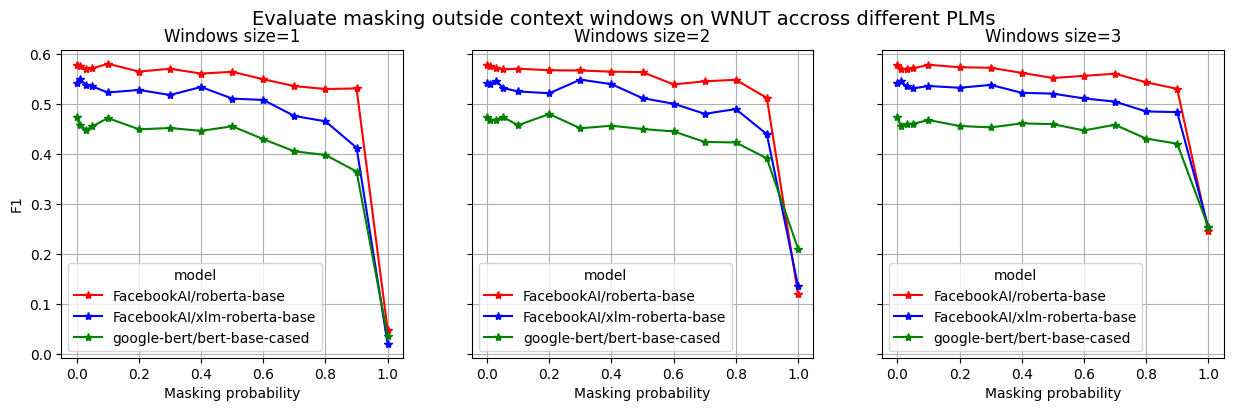

In [18]:
plot_context_masking_plm_results(1,2,3, 
                                 dataframes=[wnut_bert_context_outside_masked, 
                                             wnut_roberta_context_outside_masked, 
                                             wnut_xlmr_context_outside_masked], 
                                 pivot_col="model",
                                 pivot_ind=["mask_ratio", "windows_size"], 
                                 pivot_values="f1",
                                 title="Evaluate masking outside context windows on WNUT accross different PLMs")

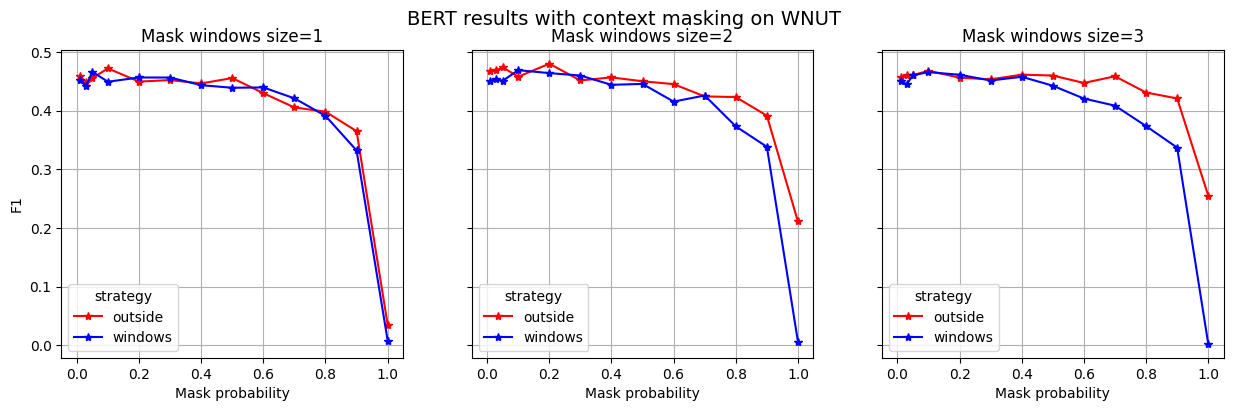

In [19]:
# Context masking
# BERT
plot_context_masking_results(1, 2, 3, inp_data=wnut_bert_context_masked, pivot_col="strategy", pivot_ind=["mask_ratio", "windows_size"], pivot_values="f1", title="BERT results with context masking on WNUT")

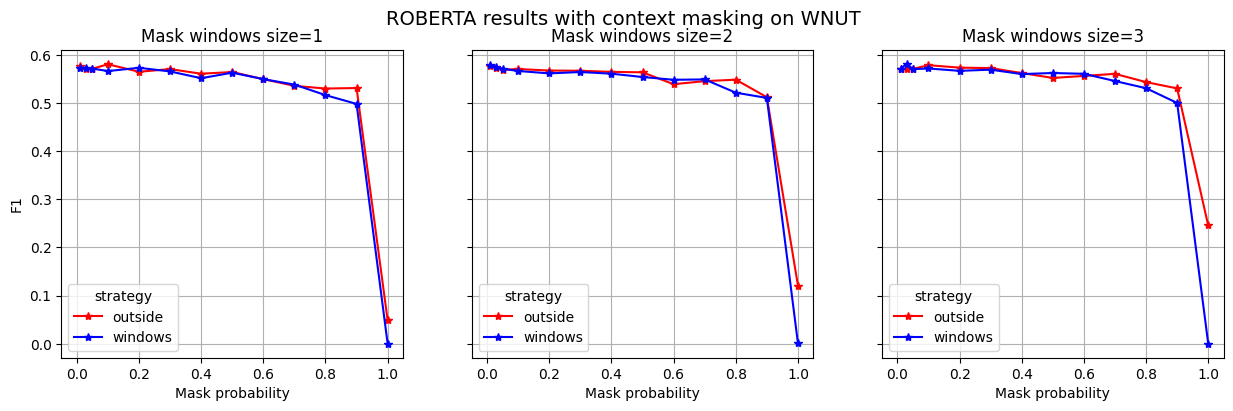

In [20]:
# ROBERTA
plot_context_masking_results(1, 2, 3, inp_data=wnut_roberta_context_masked, pivot_col="strategy", pivot_ind=["mask_ratio", "windows_size"], pivot_values="f1", title="ROBERTA results with context masking on WNUT")

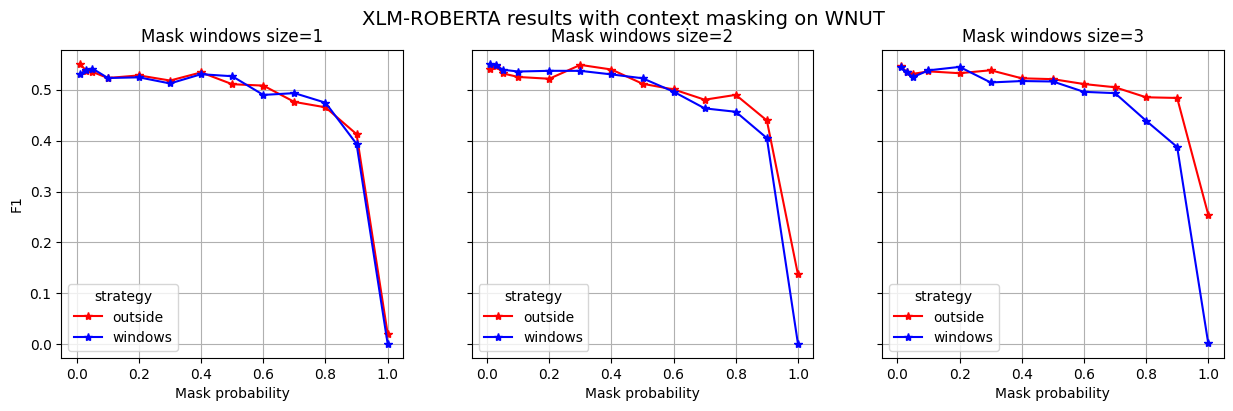

In [21]:
# XLM-ROBERTA
plot_context_masking_results(1, 2, 3, inp_data=wnut_xlmr_context_masked, pivot_col="strategy", pivot_ind=["mask_ratio", "windows_size"], pivot_values="f1", title="XLM-ROBERTA results with context masking on WNUT")

In [22]:
def get_best_context_masking(*dataframe, strategies=["outside", "windows"], sort_by=["f1"]):
    best_results = [df.loc[(df.mask_ratio >= 0.1) & (df.strategy == strat)].sort_values(by=sort_by, ascending=False).head(1) for strat in strategies for df in dataframe]
    return pd.concat(best_results).reset_index(drop=True)

def get_best_entity_masking(*dataframe, sort_by=["f1"]):
    best_results = [df.loc[(df.mask_ratio >= 0.1)].sort_values(by=sort_by, ascending=False).head(1) for df in dataframe]
    return pd.concat(best_results).reset_index(drop=True)
    

In [23]:
best_wnut_entity_masking = get_best_entity_masking(wnut_bert_entity_masked, wnut_roberta_entity_masked, wnut_xlmr_entity_masked)
best_wnut_context_masking = get_best_context_masking(wnut_bert_context_masked, wnut_roberta_context_masked, wnut_xlmr_context_masked)

In [24]:
best_conll_entity_masking = get_best_entity_masking(conll_bert_entity_masked, conll_roberta_entity_masked, conll_xlmr_entity_masked)
best_conll_context_masking = get_best_context_masking(conll_bert_context_masked, conll_roberta_context_masked, conll_xlmr_context_masked)

In [25]:
# Concatenate best results for baseline (without masks) and masking results
best_results_df = pd.concat([baselines_df, 
                             best_conll_entity_masking, 
                             best_conll_context_masking,
                             best_wnut_entity_masking, 
                             best_wnut_context_masking
                            ]).reset_index(drop=True).drop(columns=["run"]).fillna({"windows_size": 0, "strategy": "entity"})

In [26]:
def plot_best_entity_context_masking(df, group_by="model"):
    dataset = df.dataset.tolist()[0]
    grouped = df.groupby(group_by)    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=True, sharey=True)
    for i, group in enumerate(grouped.groups):
        grouped.get_group(group).plot(x="strategy", 
                                      kind="bar",
                                      grid=True, 
                                      style=["r", "b", "g"],
                                      title=f"{group}",
                                      ax=ax[i],
                                      legend=False
                                     )
        
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.setp(ax, xlabel="Masking strategies")
    plt.setp(ax[0], ylabel="Evaluation")
    fig.suptitle(f"Compare entity and context masking for {dataset}", size=14)
    

In [27]:
wnut_entity_context_merged = pd.concat([best_wnut_context_masking[["dataset", "model", "strategy", "precision", "recall", "f1"]], best_wnut_entity_masking[["model", "precision", "recall", "f1"]]]).fillna("entity")
conll_entity_context_merged = pd.concat([best_conll_context_masking[["dataset", "model", "strategy", "precision", "recall", "f1"]], best_conll_entity_masking[["model", "precision", "recall", "f1"]]]).fillna("entity")

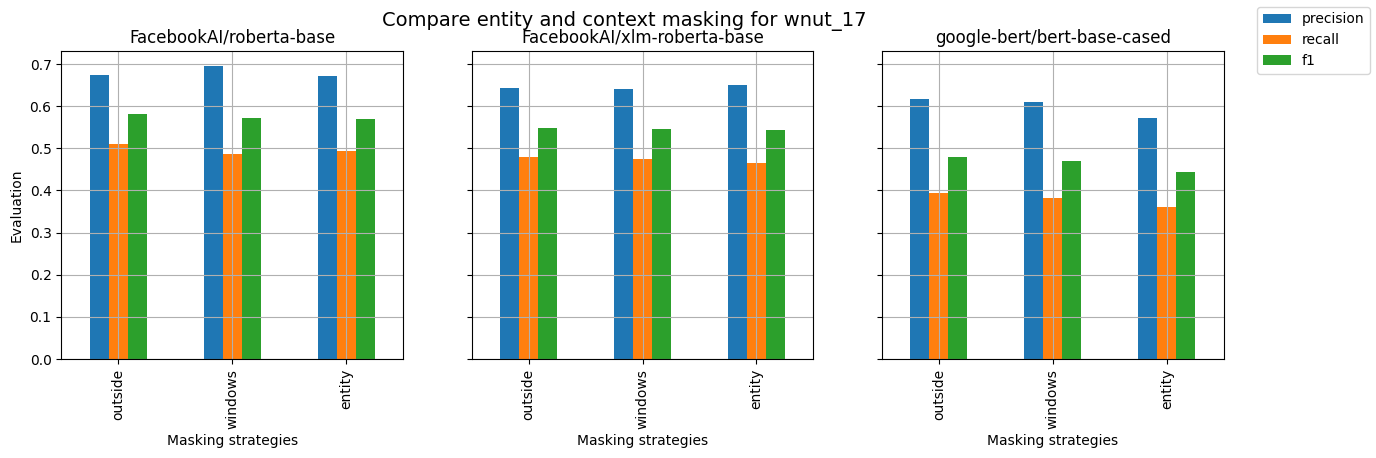

In [28]:
plot_best_entity_context_masking(wnut_entity_context_merged)

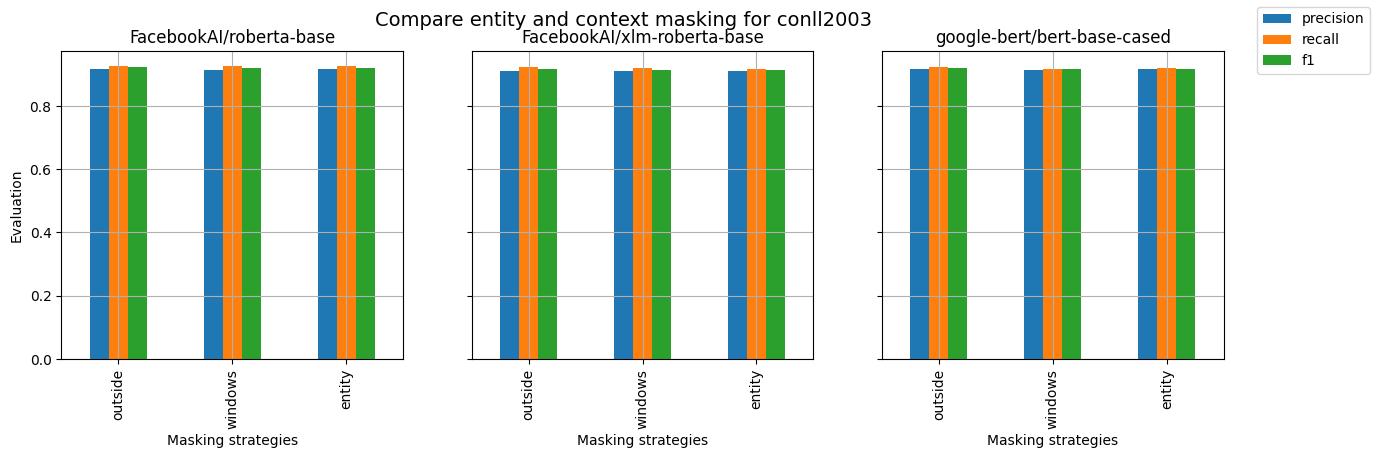

In [29]:
plot_best_entity_context_masking(conll_entity_context_merged)

In [30]:
best_results_df.head()

,dataset,model,windows_size,strategy,mask_ratio,epochs,learning_rate,batch,precision,recall,f1
0,conll2003,FacebookAI/roberta-base,0.0,no_mask,0.0,7,0.000005,16,0.918300,0.929356,0.923794
1,conll2003,FacebookAI/xlm-roberta-base,0.0,no_mask,0.0,5,0.000030,16,0.910173,0.920326,0.915221
2,conll2003,google-bert/bert-base-cased,0.0,no_mask,0.0,7,0.000030,16,0.913754,0.921034,0.917379
3,wnut_17,FacebookAI/roberta-base,0.0,no_mask,0.0,7,0.000030,16,0.667476,0.509731,0.578035
4,wnut_17,FacebookAI/xlm-roberta-base,0.0,no_mask,0.0,5,0.000030,16,0.616293,0.483781,0.542056


In [31]:
best_results_df.to_csv("./best_results.tsv", sep="\t", header=True)

In [32]:
best_results_df.head()

,dataset,model,windows_size,strategy,mask_ratio,epochs,learning_rate,batch,precision,recall,f1
0,conll2003,FacebookAI/roberta-base,0.0,no_mask,0.0,7,0.000005,16,0.918300,0.929356,0.923794
1,conll2003,FacebookAI/xlm-roberta-base,0.0,no_mask,0.0,5,0.000030,16,0.910173,0.920326,0.915221
2,conll2003,google-bert/bert-base-cased,0.0,no_mask,0.0,7,0.000030,16,0.913754,0.921034,0.917379
3,wnut_17,FacebookAI/roberta-base,0.0,no_mask,0.0,7,0.000030,16,0.667476,0.509731,0.578035
4,wnut_17,FacebookAI/xlm-roberta-base,0.0,no_mask,0.0,5,0.000030,16,0.616293,0.483781,0.542056


In [33]:
def plot_best_results(df, group_by="model"):
    dataset = df.dataset.tolist()[0]
    grouped = df.groupby(group_by)    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharex=True, sharey=True)
    for i, group in enumerate(grouped.groups):
        grouped.get_group(group).plot(x="model", 
                                      kind="bar",
                                      grid=True, 
                                      style=["r", "b", "g"],
                                      title=f"{group}",
                                      ax=ax[i],
                                      legend=False
                                     )
        
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.setp(ax, xlabel="Masking strategies")
    plt.setp(ax[0], ylabel="Evaluation")
    fig.suptitle(f"Compare all strategies", size=14)
    

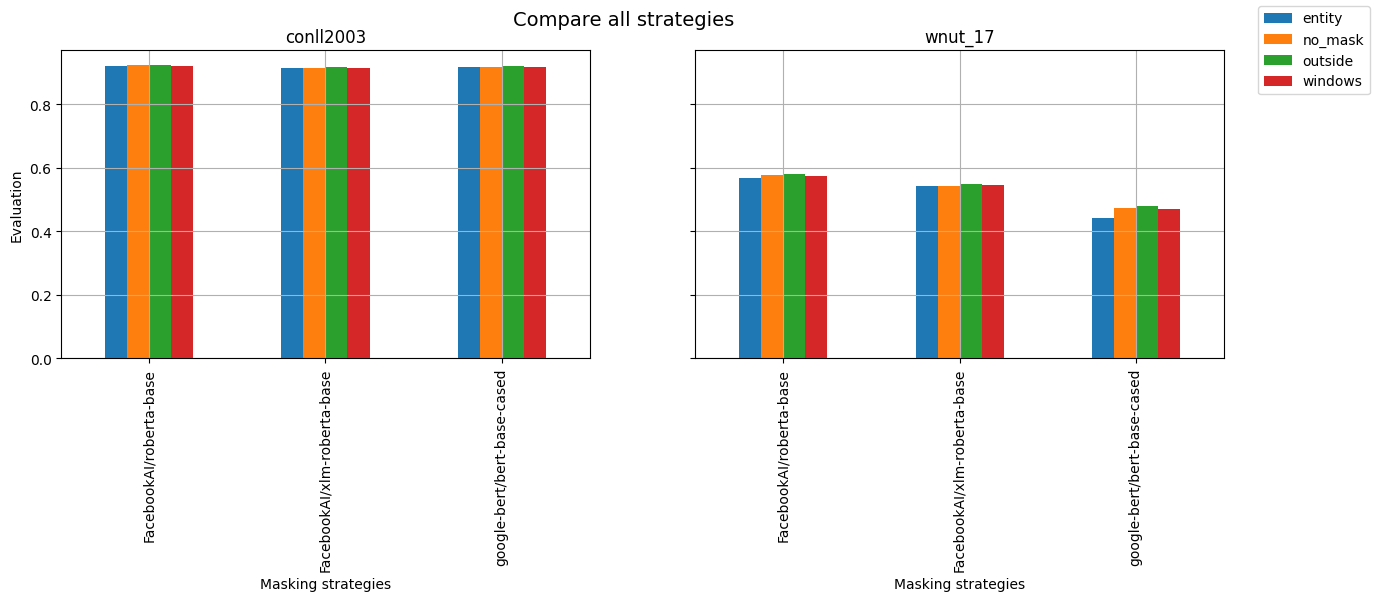

In [34]:
plot_best_results(best_results_df.pivot(index=["model", "dataset"], columns="strategy", values="f1").reset_index(), group_by=["dataset"])